In [2]:
import os

import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearnex import patch_sklearn
from tqdm.notebook import tqdm

# patch_sklearn()

import tensorflow as tf
from tensorflow import keras
from keras import layers
from scikeras.wrappers import KerasClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold, RepeatedKFold, \
    train_test_split
from sklearn.preprocessing import LabelBinarizer
from utils import OneHotEncoder
from ultility_functions import OneCycleScheduler, plot_lr_vs_loss, get_model, find_learning_rate, EarlyStoppingUp

print(tf.__version__)
print(tf.keras.__version__)
random_state = 2111

2.11.0
2.9.0


In [3]:
df = pd.read_csv('./slac/Contents of SLAC/slac.csv', usecols=['id','genre', 'subgenre', 'title'])
ids = df.id.tolist()
path = './slac/embeddings/'
emb = KeyedVectors.load_word2vec_format(path+'slac.bin')
data = np.array([emb[i] for i in ids])
emb_sets = {
    'ALL' : data,
}

In [4]:
genre = np.array(df.genre).reshape(-1, 1)

lb = LabelBinarizer()
lb_labels = lb.fit_transform(genre)

num_input, num_output = data.shape[1], lb_labels.shape[1]

print(f'genre.shape={genre.shape}',
      f'lb.classes_={lb.classes_}',
      f'data.shape={data.shape}',
      f'lb_labels.shape={lb_labels.shape}',
      f'(num_input, num_output)={(num_input, num_output)}', sep='\n')


genre.shape=(250, 1)
lb.classes_=['Blues' 'Classical' 'Jazz' 'Rap' 'Rock']
data.shape=(250, 100)
lb_labels.shape=(250, 5)
(num_input, num_output)=(100, 5)


In [5]:
def create_n_model(n_layers=1, kernel_init:str=None, activation_fn:str="relu", alpha_rate=.2, lr=.01):
    model = keras.Sequential()
    # Input Layer
    model.add(layers.BatchNormalization(input_shape=(num_input,)))  # Normalization of inputs
    model.add(layers.AlphaDropout(rate=alpha_rate))
    model.add(layers.Dense(200, activation=activation_fn, kernel_initializer=kernel_init))
    model.add(layers.AlphaDropout(rate=alpha_rate))
    # Hidden Layers
    for i in range(n_layers):
        model.add(layers.Dense(100/(2**i), activation=activation_fn, kernel_initializer=kernel_init))
        model.add(layers.AlphaDropout(rate=alpha_rate))
    # Output Layers
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=lr),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

    return model

(array([38.,  0., 40.,  0.,  0., 41.,  0., 43.,  0., 38.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

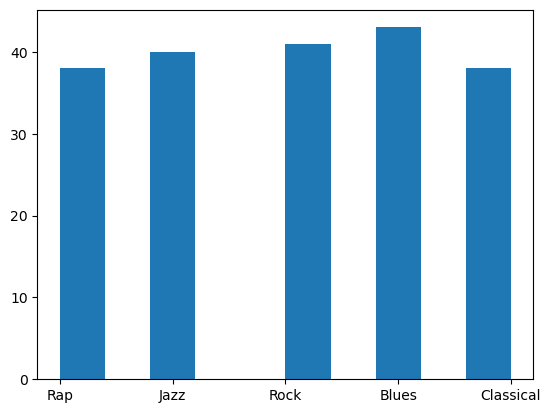

In [6]:
# Paper does not split data; Cross val score without split is (with alpha_rate=.2) ~0.876 > 0.864

X_train, X_test, y_train, y_test = train_test_split(
    data, lb_labels, test_size=0.20, random_state=random_state)

plt.hist(lb.inverse_transform(y_train))

In [17]:
# alpha_rate=0.3 works better for the split dataset
net_params = {"n_layers" : 2, "kernel_init" : "lecun_normal", "activation_fn" : "selu", "alpha_rate" : .3, "lr": .01, "epochs" : 100, "batch_size" : 50}

neural_network_cv = KerasClassifier(model=create_n_model,
                                    verbose=0,
                                    **net_params)

get_model(neural_network_cv, net_params).summary()

# early_stopping_cb = EarlyStoppingUp(patience=10, restore_best_weights=True, start_from_epoch=0)

# onecycle = OneCycleScheduler(math.ceil(len(data) / net_params["batch_size"]) * net_params["epochs"], max_rate=5e-2)

# fit_params = {"callbacks" : [early_stopping_cb]}

scores = cross_val_score(neural_network_cv, X_train, y_train,
                         cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0,
                         fit_params=None)

print(scores)
m = np.mean(scores)
s = np.std(scores)
print('Accuracy: %.3f (%.3f)' % (m, s))


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 alpha_dropout_40 (AlphaDrop  (None, 100)              0         
 out)                                                            
                                                                 
 dense_40 (Dense)            (None, 200)               20200     
                                                                 
 alpha_dropout_41 (AlphaDrop  (None, 200)              0         
 out)                                                            
                                                                 
 dense_41 (Dense)            (None, 100)               20100     
                                                     

In [18]:
def create_model():
    model = keras.Sequential()

    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[keras.metrics.CategoricalAccuracy(name='accuracy')])

    return model


neural_network_base = KerasClassifier(model=create_model,
                                 epochs=100,
                                 batch_size=50,
                                 verbose=0)

scores_base = cross_val_score(neural_network_base, X_train, y_train,
                         cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0)

print(scores_base)
m_base = np.mean(scores_base)
s_base = np.std(scores_base)
print('Accuracy: %.3f (%.3f)' % (m_base, s_base))

[0.8  0.85 0.8  0.95 0.9  0.55 0.65 0.75 0.8  0.8 ]
Accuracy: 0.785 (0.110)


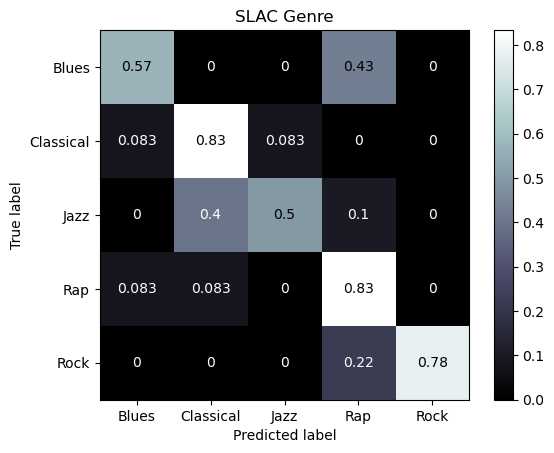

In [19]:
predicted = cross_val_predict(neural_network_cv, X_test, y_test,
                              cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0)

disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(y_test), y_pred=lb.inverse_transform(predicted), cmap='bone', normalize='true')

disp.ax_.set_title('SLAC Genre')
plt.show()

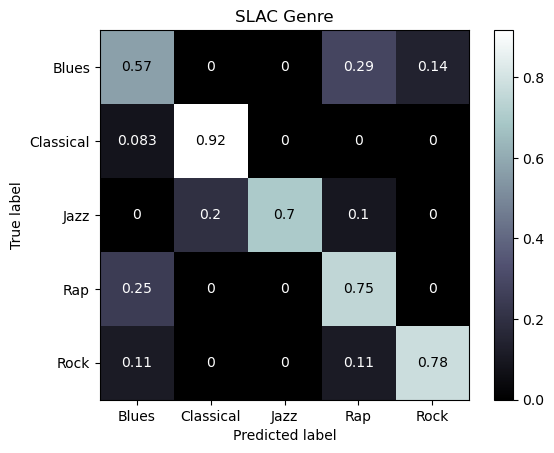

In [20]:
predicted_base = cross_val_predict(neural_network_base, X_test, y_test,
                              cv=KFold(10, shuffle=True, random_state=random_state), n_jobs=-1, verbose=0)

disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(y_test), y_pred=lb.inverse_transform(predicted_base), cmap='bone', normalize='true')

disp.ax_.set_title('SLAC Genre')
plt.show()

In [21]:
net_params_f = net_params

# early_stopping_cb = EarlyStoppingUp(patience=50, restore_best_weights=True, start_from_epoch=50)

# fit_params_f = {"callbacks" : [onecycle, early_stopping_cb]}

nn_final = KerasClassifier(model=create_n_model,
                           verbose=1,
                           **net_params_f)

model_f = get_model(nn_final, net_params_f)


history = model_f.fit(x=X_train, y=y_train, validation_split=.2, epochs=net_params_f["epochs"], batch_size=net_params_f["batch_size"],initial_epoch=0) # **fit_params_f)

Epoch 1/100
4/4 [==============================] - 1s 47ms/step - loss: 2.1856 - accuracy: 0.2500 - val_loss: 1.3679 - val_accuracy: 0.4500
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 1.9063 - accuracy: 0.2812 - val_loss: 1.9298 - val_accuracy: 0.4500
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 1.8395 - accuracy: 0.3438 - val_loss: 1.6782 - val_accuracy: 0.4250
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 1.4014 - accuracy: 0.4375 - val_loss: 1.5559 - val_accuracy: 0.5250
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 1.2483 - accuracy: 0.5437 - val_loss: 1.6818 - val_accuracy: 0.6500
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 1.3217 - accuracy: 0.5063 - val_loss: 1.5191 - val_accuracy: 0.5750
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1998 - accuracy: 0.5688 - val_loss: 1.7925 - val_accuracy: 0.5750
Epoch 8/100
4/4 [=========

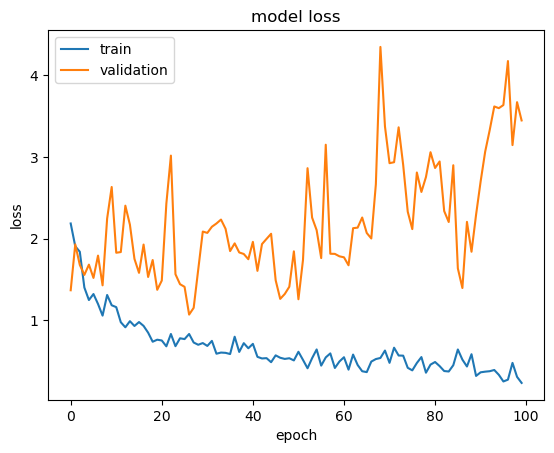

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# model_f.evaluate(X_test, y_test)

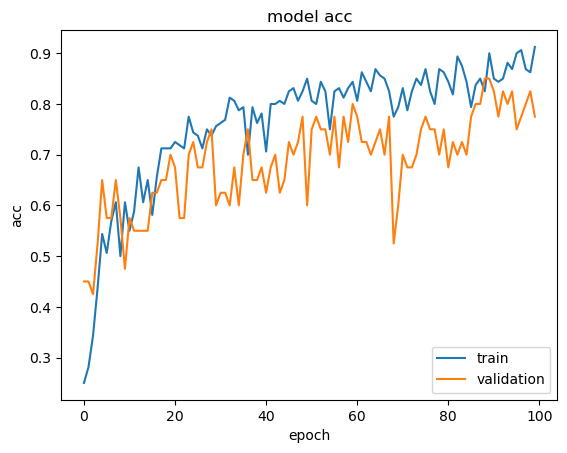

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

In [24]:
net_params_base = {"epochs": 100, "batch_size": 50, "verbose": 1}

nn_final_base = KerasClassifier(model=create_model,
                                **net_params_base)

model_base = get_model(nn_final_base, net_params_base)

history_base = model_f.fit(x=X_train, y=y_train, validation_split=.2,
                           epochs=net_params_base["epochs"], batch_size=net_params_base["batch_size"],
                           initial_epoch=0)

Epoch 1/100
4/4 [==============================] - 0s 12ms/step - loss: 0.3998 - accuracy: 0.8938 - val_loss: 3.0167 - val_accuracy: 0.7500
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2671 - accuracy: 0.9187 - val_loss: 3.0424 - val_accuracy: 0.8000
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.3976 - accuracy: 0.8875 - val_loss: 4.3177 - val_accuracy: 0.6750
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.2669 - accuracy: 0.9125 - val_loss: 3.8141 - val_accuracy: 0.6750
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2940 - accuracy: 0.9000 - val_loss: 3.3943 - val_accuracy: 0.7250
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2706 - accuracy: 0.9125 - val_loss: 3.5318 - val_accuracy: 0.7250
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.2660 - accuracy: 0.8813 - val_loss: 5.1297 - val_accuracy: 0.6750
Epoch 8/100
4/4 [=========